In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df_all = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv')
df_all.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [3]:
df_all.columns = df_all.columns.str.lower().str.replace(' ', '_')


<Axes: xlabel='final_price', ylabel='Count'>

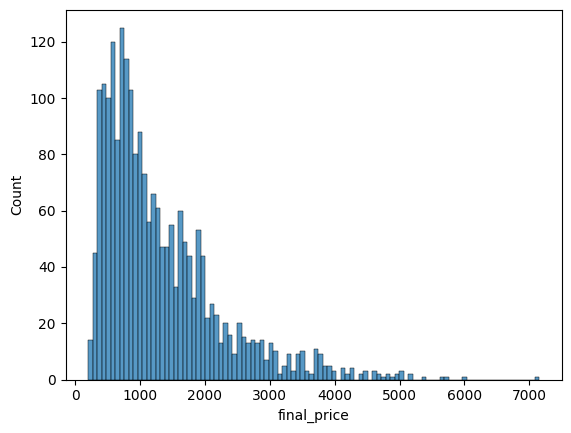

In [4]:
sns.histplot(df_all['final_price'], bins = 100)

In [5]:
df = df_all[['ram', 'storage', 'screen', 'final_price']]

In [6]:
df

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01
...,...,...,...,...
2155,16,1000,17.3,2699.99
2156,16,1000,17.3,2899.99
2157,32,1000,17.3,3399.99
2158,16,1000,13.4,1899.99


## Question 1
### There's one column with missing values. What is it?

In [7]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

## Question 2
### What's the median (50% percentile) for variable 'ram'?

In [9]:
df.ram.describe()

count    2160.000000
mean       15.413889
std         9.867815
min         4.000000
25%         8.000000
50%        16.000000
75%        16.000000
max       128.000000
Name: ram, dtype: float64

## Question 3
### We need to deal with missing values for the column from Q1.
### We have two options: fill it with 0 or with the mean of this variable.
### Try both options. For each, train a linear regression model without regularization using the code from the lessons.
### For computing the mean, use the training only!
### Use the validation dataset to evaluate the models and compare the RMSE of each option.
### Round the RMSE scores to 2 decimal digits using round(score, 2)
### Which option gives better RMSE?

In [37]:
np.random.seed(42)

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

# y_train = np.log1p(df_train.final_price.values)
# y_val = np.log1p(df_val.final_price.values)
# y_test = np.log1p(df_test.final_price.values)

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [28]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [38]:
df_train_zero = df_train.copy()
df_train_zero.screen = df_train_zero.screen.fillna(0)


X_train = df_train_zero
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

round(rmse(y_train, y_pred),2)

602.39

In [39]:
df_train_mean = df_train.copy()
df_train_mean.screen = df_train_mean.screen.fillna(df_train_mean.screen.mean())


X_train = df_train_mean
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

round(rmse(y_train, y_pred),2)

602.18

## Question 4
### Now let's train a regularized linear regression.
### For this question, fill the NAs with 0.
### Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
### Use RMSE to evaluate the model on the validation dataset.
### Round the RMSE scores to 2 decimal digits.
### Which r gives the best RMSE?


In [19]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

np.random.seed(42)

rms = {}



for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    X_train = df_train.copy().fillna(0)
    X_val = df_val.copy().fillna(0)
    
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    
    
    rms[str(r)] = round(rmse(y_val, y_pred),2)
    
for k in rms:
    if rms[k]== min(rms.values()):
        print(k)
        break

0


In [20]:
rms

{'0': 0.43,
 '0.01': 0.43,
 '0.1': 0.43,
 '1': 0.43,
 '5': 0.46,
 '10': 0.51,
 '100': 0.67}

### Question 5
#### We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
#### Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
#### For each seed, do the train/validation/test split with 60%/20%/20% distribution.
#### Fill the missing values with 0 and train a model without regularization.
#### For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
#### What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
#### Round the result to 3 decimal digits (round(std, 3))

In [24]:
rand_seed_dict = {}

for r in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(r)
    
    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

#     y_train = np.log1p(df_train.final_price.values)
#     y_val = np.log1p(df_val.final_price.values)
#     y_test = np.log1p(df_test.final_price.values)

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    
    X_train = df_train.copy().fillna(0)
    X_val = df_val.copy().fillna(0)
    
    w_0, w = train_linear_regression(X_train, y_train)
    
    y_pred = w_0 + X_val.dot(w)
    rand_seed_dict[str(r)] = rmse(y_val, y_pred)
    
# list(rand_seed_dict.values())
round(np.std(list(rand_seed_dict.values())), 3) 

29.176

### Question 6
#### Split the dataset like previously, use seed 9.
#### Combine train and validation datasets.
#### Fill the missing values with 0 and train a model with r=0.001.
#### What's the RMSE on the test dataset?

In [26]:
for r in [9]:
    np.random.seed(r)
    
    n = len(df)

    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

#     y_train = np.log1p(df_train.median_house_value.values)
#     y_val = np.log1p(df_val.median_house_value.values)
#     y_test = np.log1p(df_test.median_house_value.values)

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    
    X_train_val = pd.concat([df_train.copy(), df_val.copy()]).fillna(0)
    X_test = df_test.copy().fillna(0)
    
    w_0, w = train_linear_regression_reg(X_train_val, np.concatenate([y_train, y_val]), r=0.001)
    
    y_pred = w_0 + X_test.dot(w)
    print(rmse(y_test, y_pred))
    
# list(rand_seed_dict.values()round(np.std(list(rand_seed_dict.values())), 3) 




608.609982204956


In [32]:
df_train_median.screen.median()

15.6